In [25]:
#Import Dependencies

import pandas as pd
from uszipcode import ZipcodeSearchEngine
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
#Data Retrieval

from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:

# Note that you'll have to paste our API key here. I haven't included it since this will go to the Github repo
client = Socrata("data.lacity.org", "LLaYxNjJnTyIyES7N63sJAUDv")


#Only getting the first 1000 rows to ease computational requirements but when we have all of our codes written
#we should grab the full dataset.
result_list = client.get("7fvc-faax", limit=2000000)

# Convert to pandas DataFrame
crime_df = pd.DataFrame.from_records(result_list)
crime_df.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd
0,01,Central,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2017-11-02T00:00:00.000,2017-11-02T00:00:00.000,170101261,1800 S BROADWAY,"{'type': 'Point', 'coordinates': [-118.2647, 3...",0329 2004,203,OTHER BUSINESS,0195,IC,Invest Cont,2130,58,H,M,NaN,NaN
1,01,Central,888,888,NaN,NaN,NaN,TRESPASSING,ALAMEDA ST,2017-10-30T00:00:00.000,2017-10-30T00:00:00.000,170128267,LOS ANGELES ST,"{'type': 'Point', 'coordinates': [-118.2318, 3...",0910 2028 1501 2004,135,MTA PROPERTY OR PARKING LOT,0119,IC,Invest Cont,2230,48,H,M,NaN,NaN
2,20,Olympic,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2018-06-30T00:00:00.000,2018-06-30T00:00:00.000,182013514,800 S KENMORE AV,"{'type': 'Point', 'coordinates': [-118.2981, 3...",0329,122,"VEHICLE, PASSENGER/TRUCK",2045,IC,Invest Cont,0205,32,H,M,NaN,NaN
3,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,NaN,2017-11-01T00:00:00.000,2017-11-01T00:00:00.000,170128444,300 S SANTA FE AV,"{'type': 'Point', 'coordinates': [-118.2326, 3...",1609 1307 0358 0344,101,STREET,0139,IC,Invest Cont,1730,20,H,M,NaN,NaN
4,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,SAN PEDRO ST,2017-11-01T00:00:00.000,2017-11-01T00:00:00.000,170128445,3RD ST,"{'type': 'Point', 'coordinates': [-118.2411, 3...",0344 1609 1307 0358,101,STREET,0138,IC,Invest Cont,2200,22,H,F,NaN,NaN


In [3]:
#Data Cleaning

# Converting "date_occ" row to a datetime object
crime_df["date_occ"]=pd.to_datetime(crime_df["date_occ"])

#IGNORE THIS
#Strip month and year from date
#converted_dates = []
#for date in crime_df["date_occ"]:
    #converted_time = datetime.strptime(date, "Y%-%m-%d")
    #converted_dates.append(converted_time)

#Create new columns in Crime dataframe for Month and Year
crime_df["Month"] = [date.month for date in crime_df["date_occ"]]
crime_df["Year"] = [date.year for date in crime_df["date_occ"]]
crime_df.head()


,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,Month,Year
0,01,Central,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2017-11-02,2017-11-02T00:00:00.000,170101261,1800 S BROADWAY,"{'type': 'Point', 'coordinates': [-118.2647, 3...",0329 2004,203,OTHER BUSINESS,0195,IC,Invest Cont,2130,58,H,M,NaN,NaN,11,2017
1,01,Central,888,888,NaN,NaN,NaN,TRESPASSING,ALAMEDA ST,2017-10-30,2017-10-30T00:00:00.000,170128267,LOS ANGELES ST,"{'type': 'Point', 'coordinates': [-118.2318, 3...",0910 2028 1501 2004,135,MTA PROPERTY OR PARKING LOT,0119,IC,Invest Cont,2230,48,H,M,NaN,NaN,10,2017
2,20,Olympic,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2018-06-30,2018-06-30T00:00:00.000,182013514,800 S KENMORE AV,"{'type': 'Point', 'coordinates': [-118.2981, 3...",0329,122,"VEHICLE, PASSENGER/TRUCK",2045,IC,Invest Cont,0205,32,H,M,NaN,NaN,6,2018
3,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,NaN,2017-11-01,2017-11-01T00:00:00.000,170128444,300 S SANTA FE AV,"{'type': 'Point', 'coordinates': [-118.2326, 3...",1609 1307 0358 0344,101,STREET,0139,IC,Invest Cont,1730,20,H,M,NaN,NaN,11,2017
4,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,SAN PEDRO ST,2017-11-01,2017-11-01T00:00:00.000,170128445,3RD ST,"{'type': 'Point', 'coordinates': [-118.2411, 3...",0344 1609 1307 0358,101,STREET,0138,IC,Invest Cont,2200,22,H,F,NaN,NaN,11,2017


In [4]:
#crime_df.to_csv("Data/Raw_DataSet.csv")

In [5]:
crime_df.loc[crime_df['Year'] != 2018, :]

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,Month,Year
0,01,Central,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2017-11-02,2017-11-02T00:00:00.000,170101261,1800 S BROADWAY,"{'type': 'Point', 'coordinates': [-118.2647, 3...",0329 2004,203,OTHER BUSINESS,0195,IC,Invest Cont,2130,58,H,M,NaN,NaN,11,2017
1,01,Central,888,888,NaN,NaN,NaN,TRESPASSING,ALAMEDA ST,2017-10-30,2017-10-30T00:00:00.000,170128267,LOS ANGELES ST,"{'type': 'Point', 'coordinates': [-118.2318, 3...",0910 2028 1501 2004,135,MTA PROPERTY OR PARKING LOT,0119,IC,Invest Cont,2230,48,H,M,NaN,NaN,10,2017
3,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,NaN,2017-11-01,2017-11-01T00:00:00.000,170128444,300 S SANTA FE AV,"{'type': 'Point', 'coordinates': [-118.2326, 3...",1609 1307 0358 0344,101,STREET,0139,IC,Invest Cont,1730,20,H,M,NaN,NaN,11,2017
4,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,SAN PEDRO ST,2017-11-01,2017-11-01T00:00:00.000,170128445,3RD ST,"{'type': 'Point', 'coordinates': [-118.2411, 3...",0344 1609 1307 0358,101,STREET,0138,IC,Invest Cont,2200,22,H,F,NaN,NaN,11,2017
5,01,Central,745,745,NaN,NaN,NaN,VANDALISM - MISDEAMEANOR ($399 OR UNDER),NaN,2017-11-02,2017-11-02T00:00:00.000,170128448,500 S SAN PEDRO ST,"{'type': 'Point', 'coordinates': [-118.2455, 3...",0329 1609,502,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",0156,IC,Invest Cont,0055,NaN,X,X,UNKNOWN WEAPON/OTHER WEAPON,500,11,2017
7,01,Central,510,510,NaN,NaN,NaN,VEHICLE - STOLEN,NaN,2017-11-01,2017-11-02T00:00:00.000,170128465,500 N FIGUEROA ST,"{'type': 'Point', 'coordinates': [-118.2469, 3...",NaN,707,GARAGE/CARPORT,0111,IC,Invest Cont,2200,16,NaN,NaN,NaN,NaN,11,2017
8,01,Central,888,888,NaN,NaN,NaN,TRESPASSING,NaN,2017-11-02,2017-11-02T00:00:00.000,170128466,500 WALL ST,"{'type': 'Point', 'coordinates': [-118.2458, 3...",1501 2004,516,NaN,0156,IC,Invest Cont,1000,NaN,X,X,NaN,NaN,11,2017
9,01,Central,210,210,NaN,NaN,NaN,ROBBERY,FIGUEROA,2017-11-01,2017-11-02T00:00:00.000,170128479,7TH ST,"{'type': 'Point', 'coordinates': [-118.2599, 3...",0913 0432 0337 0344 0443 1820,101,STREET,0162,IC,Invest Cont,0001,48,H,M,FOLDING KNIFE,204,11,2017
10,01,Central,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2017-11-01,2017-11-02T00:00:00.000,170128482,500 S GRAND AV,"{'type': 'Point', 'coordinates': [-118.254, 34...",1307 0329,203,OTHER BUSINESS,0152,IC,Invest Cont,2230,30,B,F,NaN,NaN,11,2017
13,01,Central,442,442,NaN,NaN,NaN,SHOPLIFTING - PETTY THEFT ($950 & UNDER),NaN,2017-11-02,2017-11-02T00:00:00.000,170128490,700 W 7TH ST,"{'type': 'Point', 'coordinates': [-118.2577, 3...",2004 0344,406,OTHER STORE,0162,IC,Invest Cont,1625,36,W,M,NaN,NaN,11,2017


In [6]:
# Code to look at crime descriptions and their associated crime code
#All the numbers in this data set are stored as objects rather than intergers.
#We may want to convert all numeric columns to numbers but here I'm just converting the crime codes to numbers
crime_df["crm_cd"] = pd.to_numeric(crime_df["crm_cd"])

#Groups by crime description then look at average crime code. This matches 
crime_code = crime_df.groupby("crm_cd_desc")
crime_code = crime_code.mean()
crime_code = crime_code.drop(["Month","Year"], axis=1)
crime_code

,crm_cd
crm_cd_desc,
ABORTION/ILLEGAL,952.0
ARSON,648.0
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,231.0
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",230.0
ATTEMPTED ROBBERY,220.0
BATTERY - SIMPLE ASSAULT,624.0
BATTERY ON A FIREFIGHTER,622.0
BATTERY POLICE (SIMPLE),623.0
BATTERY WITH SEXUAL CONTACT,860.0


In [7]:
#Splitting the latitude and longitudes

lat = []
lon = []
split_lat_longs = []

# For each row in a varible,
for x in range(len(crime_df["location"])):
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        location = crime_df["location_1"][x]["coordinates"]
        split_lat_longs.append(location)
        lon.append(location[0])
        lat.append(location[1])
        # Split the row by comma and append
        # everything after the comma to lon
        #lon.append(location.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

crime_df["Latitude"] = lat
crime_df["Longitude"] = lon

In [8]:
#Display the dataframe
crime_df.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,Month,Year,Latitude,Longitude
0,01,Central,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2017-11-02,2017-11-02T00:00:00.000,170101261,1800 S BROADWAY,"{'type': 'Point', 'coordinates': [-118.2647, 3...",0329 2004,203,OTHER BUSINESS,0195,IC,Invest Cont,2130,58,H,M,NaN,NaN,11,2017,34.0328,-118.2647
1,01,Central,888,888,NaN,NaN,NaN,TRESPASSING,ALAMEDA ST,2017-10-30,2017-10-30T00:00:00.000,170128267,LOS ANGELES ST,"{'type': 'Point', 'coordinates': [-118.2318, 3...",0910 2028 1501 2004,135,MTA PROPERTY OR PARKING LOT,0119,IC,Invest Cont,2230,48,H,M,NaN,NaN,10,2017,34.0577,-118.2318
2,20,Olympic,740,740,NaN,NaN,NaN,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",NaN,2018-06-30,2018-06-30T00:00:00.000,182013514,800 S KENMORE AV,"{'type': 'Point', 'coordinates': [-118.2981, 3...",0329,122,"VEHICLE, PASSENGER/TRUCK",2045,IC,Invest Cont,0205,32,H,M,NaN,NaN,6,2018,34.0561,-118.2981
3,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,NaN,2017-11-01,2017-11-01T00:00:00.000,170128444,300 S SANTA FE AV,"{'type': 'Point', 'coordinates': [-118.2326, 3...",1609 1307 0358 0344,101,STREET,0139,IC,Invest Cont,1730,20,H,M,NaN,NaN,11,2017,34.0460,-118.2326
4,01,Central,330,330,NaN,NaN,NaN,BURGLARY FROM VEHICLE,SAN PEDRO ST,2017-11-01,2017-11-01T00:00:00.000,170128445,3RD ST,"{'type': 'Point', 'coordinates': [-118.2411, 3...",0344 1609 1307 0358,101,STREET,0138,IC,Invest Cont,2200,22,H,F,NaN,NaN,11,2017,34.0467,-118.2411


In [9]:
#Looking for the zipcodes asociated with the latitudes and longitudes

from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()
zipcodes = []
counter = 0
counter_2 = 0
for index, row in crime_df.iterrows():

    #Get zipcodes based on lat-longs
    try:
        crime_lat = row["Latitude"]
        crime_lon = row["Longitude"]
        zipcode = search.by_coordinate(crime_lat, crime_lon, returns=1)
        zipcodes.append(zipcode[0]["Zipcode"])
        counter_2 = counter_2+1
    except:
        zipcodes.append("NaN")
        counter = counter + 1
        print(f"{counter} exceptions identified on index {counter_2}")
        counter_2 = counter_2+1

crime_df["Zip Code"] = zipcodes

1 exceptions identified on index 1745
2 exceptions identified on index 1776
3 exceptions identified on index 1787
4 exceptions identified on index 1802
5 exceptions identified on index 1810
6 exceptions identified on index 1888
7 exceptions identified on index 1898
8 exceptions identified on index 1909
9 exceptions identified on index 1914
10 exceptions identified on index 1985
11 exceptions identified on index 2014
12 exceptions identified on index 2056
13 exceptions identified on index 2178
14 exceptions identified on index 2184
15 exceptions identified on index 2238
16 exceptions identified on index 2317
17 exceptions identified on index 2318
18 exceptions identified on index 2431
19 exceptions identified on index 2452
20 exceptions identified on index 2488
21 exceptions identified on index 2489
22 exceptions identified on index 2491
23 exceptions identified on index 2502
24 exceptions identified on index 2541
25 exceptions identified on index 2552
26 exceptions identified on index 

206 exceptions identified on index 48151
207 exceptions identified on index 48172
208 exceptions identified on index 48334
209 exceptions identified on index 48405
210 exceptions identified on index 48406
211 exceptions identified on index 48429
212 exceptions identified on index 48595
213 exceptions identified on index 48597
214 exceptions identified on index 48604
215 exceptions identified on index 48655
216 exceptions identified on index 48660
217 exceptions identified on index 48684
218 exceptions identified on index 48693
219 exceptions identified on index 48734
220 exceptions identified on index 48771
221 exceptions identified on index 48795
222 exceptions identified on index 48826
223 exceptions identified on index 48829
224 exceptions identified on index 48906
225 exceptions identified on index 48909
226 exceptions identified on index 48944
227 exceptions identified on index 48978
228 exceptions identified on index 49019
229 exceptions identified on index 49035
230 exceptions i

406 exceptions identified on index 75039
407 exceptions identified on index 75040
408 exceptions identified on index 75079
409 exceptions identified on index 75440
410 exceptions identified on index 75494
411 exceptions identified on index 75495
412 exceptions identified on index 75698
413 exceptions identified on index 75699
414 exceptions identified on index 75700
415 exceptions identified on index 75851
416 exceptions identified on index 76026
417 exceptions identified on index 76027
418 exceptions identified on index 76028
419 exceptions identified on index 76029
420 exceptions identified on index 76066
421 exceptions identified on index 76067
422 exceptions identified on index 76068
423 exceptions identified on index 76089
424 exceptions identified on index 76106
425 exceptions identified on index 76107
426 exceptions identified on index 76108
427 exceptions identified on index 76109
428 exceptions identified on index 76110
429 exceptions identified on index 76111
430 exceptions i

605 exceptions identified on index 104690
606 exceptions identified on index 104710
607 exceptions identified on index 104750
608 exceptions identified on index 104774
609 exceptions identified on index 104798
610 exceptions identified on index 104974
611 exceptions identified on index 104980
612 exceptions identified on index 104995
613 exceptions identified on index 105054
614 exceptions identified on index 105134
615 exceptions identified on index 105318
616 exceptions identified on index 105353
617 exceptions identified on index 105385
618 exceptions identified on index 105415
619 exceptions identified on index 105428
620 exceptions identified on index 105431
621 exceptions identified on index 105433
622 exceptions identified on index 105480
623 exceptions identified on index 105508
624 exceptions identified on index 105541
625 exceptions identified on index 105581
626 exceptions identified on index 105654
627 exceptions identified on index 105662
628 exceptions identified on index

804 exceptions identified on index 113112
805 exceptions identified on index 113126
806 exceptions identified on index 113170
807 exceptions identified on index 113204
808 exceptions identified on index 113326
809 exceptions identified on index 113330
810 exceptions identified on index 113343
811 exceptions identified on index 113365
812 exceptions identified on index 113393
813 exceptions identified on index 113403
814 exceptions identified on index 113455
815 exceptions identified on index 113517
816 exceptions identified on index 113536
817 exceptions identified on index 113548
818 exceptions identified on index 113556
819 exceptions identified on index 113640
820 exceptions identified on index 113747
821 exceptions identified on index 113787
822 exceptions identified on index 113811
823 exceptions identified on index 113827
824 exceptions identified on index 113907
825 exceptions identified on index 113941
826 exceptions identified on index 113945
827 exceptions identified on index

1000 exceptions identified on index 123915
1001 exceptions identified on index 124151
1002 exceptions identified on index 124157
1003 exceptions identified on index 124159
1004 exceptions identified on index 124189
1005 exceptions identified on index 124288
1006 exceptions identified on index 124291
1007 exceptions identified on index 124643
1008 exceptions identified on index 125134
1009 exceptions identified on index 125174
1010 exceptions identified on index 125589
1011 exceptions identified on index 125615
1012 exceptions identified on index 125706
1013 exceptions identified on index 125774
1014 exceptions identified on index 125803
1015 exceptions identified on index 125976
1016 exceptions identified on index 125987
1017 exceptions identified on index 126081
1018 exceptions identified on index 126166
1019 exceptions identified on index 126220
1020 exceptions identified on index 126419
1021 exceptions identified on index 126446
1022 exceptions identified on index 126465
1023 except

1191 exceptions identified on index 139882
1192 exceptions identified on index 139916
1193 exceptions identified on index 139967
1194 exceptions identified on index 140009
1195 exceptions identified on index 140074
1196 exceptions identified on index 140087
1197 exceptions identified on index 140231
1198 exceptions identified on index 140300
1199 exceptions identified on index 140340
1200 exceptions identified on index 140373
1201 exceptions identified on index 140405
1202 exceptions identified on index 140426
1203 exceptions identified on index 140519
1204 exceptions identified on index 140571
1205 exceptions identified on index 140602
1206 exceptions identified on index 140624
1207 exceptions identified on index 140694
1208 exceptions identified on index 140700
1209 exceptions identified on index 142306
1210 exceptions identified on index 142336
1211 exceptions identified on index 142595
1212 exceptions identified on index 142613
1213 exceptions identified on index 142633
1214 except

1383 exceptions identified on index 151951
1384 exceptions identified on index 151970
1385 exceptions identified on index 152115
1386 exceptions identified on index 152118
1387 exceptions identified on index 152187
1388 exceptions identified on index 152225
1389 exceptions identified on index 152238
1390 exceptions identified on index 152251
1391 exceptions identified on index 152252
1392 exceptions identified on index 152386
1393 exceptions identified on index 152400
1394 exceptions identified on index 152423
1395 exceptions identified on index 152481
1396 exceptions identified on index 152535
1397 exceptions identified on index 152654
1398 exceptions identified on index 152656
1399 exceptions identified on index 152726
1400 exceptions identified on index 152784
1401 exceptions identified on index 152887
1402 exceptions identified on index 152893
1403 exceptions identified on index 152937
1404 exceptions identified on index 152992
1405 exceptions identified on index 153020
1406 except

1574 exceptions identified on index 205515
1575 exceptions identified on index 205535
1576 exceptions identified on index 205577
1577 exceptions identified on index 205581
1578 exceptions identified on index 205619
1579 exceptions identified on index 205629
1580 exceptions identified on index 205635
1581 exceptions identified on index 205645
1582 exceptions identified on index 205697
1583 exceptions identified on index 205701
1584 exceptions identified on index 205722
1585 exceptions identified on index 205745
1586 exceptions identified on index 205749
1587 exceptions identified on index 205750
1588 exceptions identified on index 205755
1589 exceptions identified on index 205757
1590 exceptions identified on index 205792
1591 exceptions identified on index 205831
1592 exceptions identified on index 205859
1593 exceptions identified on index 205860
1594 exceptions identified on index 205870
1595 exceptions identified on index 205884
1596 exceptions identified on index 205889
1597 except

1766 exceptions identified on index 652327
1767 exceptions identified on index 652354
1768 exceptions identified on index 652355
1769 exceptions identified on index 652370
1770 exceptions identified on index 652389
1771 exceptions identified on index 652412
1772 exceptions identified on index 652418
1773 exceptions identified on index 652613
1774 exceptions identified on index 652678
1775 exceptions identified on index 652715
1776 exceptions identified on index 652742
1777 exceptions identified on index 652759
1778 exceptions identified on index 652835
1779 exceptions identified on index 652855
1780 exceptions identified on index 652917
1781 exceptions identified on index 652925
1782 exceptions identified on index 653016
1783 exceptions identified on index 659482
1784 exceptions identified on index 659582
1785 exceptions identified on index 659597
1786 exceptions identified on index 659625
1787 exceptions identified on index 659686
1788 exceptions identified on index 659730
1789 except

1958 exceptions identified on index 708482
1959 exceptions identified on index 708599
1960 exceptions identified on index 708604
1961 exceptions identified on index 708628
1962 exceptions identified on index 708630
1963 exceptions identified on index 708646
1964 exceptions identified on index 708659
1965 exceptions identified on index 708663
1966 exceptions identified on index 708692
1967 exceptions identified on index 708698
1968 exceptions identified on index 708705
1969 exceptions identified on index 708712
1970 exceptions identified on index 708738
1971 exceptions identified on index 708777
1972 exceptions identified on index 718880
1973 exceptions identified on index 718893
1974 exceptions identified on index 718983
1975 exceptions identified on index 719054
1976 exceptions identified on index 719090
1977 exceptions identified on index 719094
1978 exceptions identified on index 719099
1979 exceptions identified on index 719122
1980 exceptions identified on index 719288
1981 except

2150 exceptions identified on index 767324
2151 exceptions identified on index 767335
2152 exceptions identified on index 767375
2153 exceptions identified on index 767408
2154 exceptions identified on index 767448
2155 exceptions identified on index 767499
2156 exceptions identified on index 767503
2157 exceptions identified on index 767525
2158 exceptions identified on index 767585
2159 exceptions identified on index 767675
2160 exceptions identified on index 767725
2161 exceptions identified on index 767760
2162 exceptions identified on index 771467
2163 exceptions identified on index 775176
2164 exceptions identified on index 776904
2165 exceptions identified on index 776906
2166 exceptions identified on index 776937
2167 exceptions identified on index 777014
2168 exceptions identified on index 777048
2169 exceptions identified on index 777146
2170 exceptions identified on index 777212
2171 exceptions identified on index 777256
2172 exceptions identified on index 777313
2173 except

2339 exceptions identified on index 1111935
2340 exceptions identified on index 1112129
2341 exceptions identified on index 1112489
2342 exceptions identified on index 1112834
2343 exceptions identified on index 1113438
2344 exceptions identified on index 1113577
2345 exceptions identified on index 1113598
2346 exceptions identified on index 1113611
2347 exceptions identified on index 1113656
2348 exceptions identified on index 1114373
2349 exceptions identified on index 1117149
2350 exceptions identified on index 1117237
2351 exceptions identified on index 1118713
2352 exceptions identified on index 1119567
2353 exceptions identified on index 1121674
2354 exceptions identified on index 1123888
2355 exceptions identified on index 1123950
2356 exceptions identified on index 1125760
2357 exceptions identified on index 1126564
2358 exceptions identified on index 1126832
2359 exceptions identified on index 1128453
2360 exceptions identified on index 1134468
2361 exceptions identified on in

2527 exceptions identified on index 1621325
2528 exceptions identified on index 1621351
2529 exceptions identified on index 1621367
2530 exceptions identified on index 1621369
2531 exceptions identified on index 1621379
2532 exceptions identified on index 1621395
2533 exceptions identified on index 1621398
2534 exceptions identified on index 1621407
2535 exceptions identified on index 1621424
2536 exceptions identified on index 1621461
2537 exceptions identified on index 1621464
2538 exceptions identified on index 1621477
2539 exceptions identified on index 1621515
2540 exceptions identified on index 1621552
2541 exceptions identified on index 1621585
2542 exceptions identified on index 1621596
2543 exceptions identified on index 1621607
2544 exceptions identified on index 1621624
2545 exceptions identified on index 1621665
2546 exceptions identified on index 1621675
2547 exceptions identified on index 1621729
2548 exceptions identified on index 1621743
2549 exceptions identified on in

2716 exceptions identified on index 1629600
2717 exceptions identified on index 1629608
2718 exceptions identified on index 1629683
2719 exceptions identified on index 1629701
2720 exceptions identified on index 1629735
2721 exceptions identified on index 1629753
2722 exceptions identified on index 1629799
2723 exceptions identified on index 1629869
2724 exceptions identified on index 1629876
2725 exceptions identified on index 1629880
2726 exceptions identified on index 1629906
2727 exceptions identified on index 1629907
2728 exceptions identified on index 1629991
2729 exceptions identified on index 1630057
2730 exceptions identified on index 1630060
2731 exceptions identified on index 1630174
2732 exceptions identified on index 1630190
2733 exceptions identified on index 1630194
2734 exceptions identified on index 1630196
2735 exceptions identified on index 1630225
2736 exceptions identified on index 1630257
2737 exceptions identified on index 1630340
2738 exceptions identified on in

2906 exceptions identified on index 1640033
2907 exceptions identified on index 1640035
2908 exceptions identified on index 1640054
2909 exceptions identified on index 1640055
2910 exceptions identified on index 1640099
2911 exceptions identified on index 1640148
2912 exceptions identified on index 1640168
2913 exceptions identified on index 1640174
2914 exceptions identified on index 1640196
2915 exceptions identified on index 1640216
2916 exceptions identified on index 1640230
2917 exceptions identified on index 1640295
2918 exceptions identified on index 1640305
2919 exceptions identified on index 1640315
2920 exceptions identified on index 1640324
2921 exceptions identified on index 1640357
2922 exceptions identified on index 1640372
2923 exceptions identified on index 1640392
2924 exceptions identified on index 1640427
2925 exceptions identified on index 1640430
2926 exceptions identified on index 1640463
2927 exceptions identified on index 1640486
2928 exceptions identified on in

3094 exceptions identified on index 1646938
3095 exceptions identified on index 1648292
3096 exceptions identified on index 1648309
3097 exceptions identified on index 1648326
3098 exceptions identified on index 1648330
3099 exceptions identified on index 1648336
3100 exceptions identified on index 1648350
3101 exceptions identified on index 1648361
3102 exceptions identified on index 1648373
3103 exceptions identified on index 1648436
3104 exceptions identified on index 1648456
3105 exceptions identified on index 1648478
3106 exceptions identified on index 1648488
3107 exceptions identified on index 1648497
3108 exceptions identified on index 1648511
3109 exceptions identified on index 1648522
3110 exceptions identified on index 1648523
3111 exceptions identified on index 1648537
3112 exceptions identified on index 1648556
3113 exceptions identified on index 1648614
3114 exceptions identified on index 1648653
3115 exceptions identified on index 1648716
3116 exceptions identified on in

3281 exceptions identified on index 1651479
3282 exceptions identified on index 1651512
3283 exceptions identified on index 1651513
3284 exceptions identified on index 1651582
3285 exceptions identified on index 1651585
3286 exceptions identified on index 1651590
3287 exceptions identified on index 1651604
3288 exceptions identified on index 1651614
3289 exceptions identified on index 1651622
3290 exceptions identified on index 1651681
3291 exceptions identified on index 1651703
3292 exceptions identified on index 1651713
3293 exceptions identified on index 1651733
3294 exceptions identified on index 1651738
3295 exceptions identified on index 1651784
3296 exceptions identified on index 1651788
3297 exceptions identified on index 1651794
3298 exceptions identified on index 1651829
3299 exceptions identified on index 1651832
3300 exceptions identified on index 1651853
3301 exceptions identified on index 1651889
3302 exceptions identified on index 1651898
3303 exceptions identified on in

3470 exceptions identified on index 1660167
3471 exceptions identified on index 1660249
3472 exceptions identified on index 1660290
3473 exceptions identified on index 1660301
3474 exceptions identified on index 1660630
3475 exceptions identified on index 1660771
3476 exceptions identified on index 1660898
3477 exceptions identified on index 1660911
3478 exceptions identified on index 1661109
3479 exceptions identified on index 1661143
3480 exceptions identified on index 1661376
3481 exceptions identified on index 1661409
3482 exceptions identified on index 1661513
3483 exceptions identified on index 1661763
3484 exceptions identified on index 1661788
3485 exceptions identified on index 1661818
3486 exceptions identified on index 1661846
3487 exceptions identified on index 1661986
3488 exceptions identified on index 1662232
3489 exceptions identified on index 1662277
3490 exceptions identified on index 1662288
3491 exceptions identified on index 1662385
3492 exceptions identified on in

3657 exceptions identified on index 1667218
3658 exceptions identified on index 1667259
3659 exceptions identified on index 1667311
3660 exceptions identified on index 1667323
3661 exceptions identified on index 1667335
3662 exceptions identified on index 1667364
3663 exceptions identified on index 1667408
3664 exceptions identified on index 1667447
3665 exceptions identified on index 1667464
3666 exceptions identified on index 1667487
3667 exceptions identified on index 1667516
3668 exceptions identified on index 1667534
3669 exceptions identified on index 1667552
3670 exceptions identified on index 1667568
3671 exceptions identified on index 1667572
3672 exceptions identified on index 1667575
3673 exceptions identified on index 1667593
3674 exceptions identified on index 1667594
3675 exceptions identified on index 1667628
3676 exceptions identified on index 1667693
3677 exceptions identified on index 1667719
3678 exceptions identified on index 1667750
3679 exceptions identified on in

3846 exceptions identified on index 1677293
3847 exceptions identified on index 1677423
3848 exceptions identified on index 1677517
3849 exceptions identified on index 1677721
3850 exceptions identified on index 1677735
3851 exceptions identified on index 1678024
3852 exceptions identified on index 1678027
3853 exceptions identified on index 1678035
3854 exceptions identified on index 1678083
3855 exceptions identified on index 1678096
3856 exceptions identified on index 1678109
3857 exceptions identified on index 1678121
3858 exceptions identified on index 1678544
3859 exceptions identified on index 1678688
3860 exceptions identified on index 1678807
3861 exceptions identified on index 1678810
3862 exceptions identified on index 1678914
3863 exceptions identified on index 1678926
3864 exceptions identified on index 1678958
3865 exceptions identified on index 1678984
3866 exceptions identified on index 1680441
3867 exceptions identified on index 1680476
3868 exceptions identified on in

4033 exceptions identified on index 1682761
4034 exceptions identified on index 1682790
4035 exceptions identified on index 1682794
4036 exceptions identified on index 1682801
4037 exceptions identified on index 1682811
4038 exceptions identified on index 1682831
4039 exceptions identified on index 1682857
4040 exceptions identified on index 1682863
4041 exceptions identified on index 1682896
4042 exceptions identified on index 1682913
4043 exceptions identified on index 1682918
4044 exceptions identified on index 1682924
4045 exceptions identified on index 1682925
4046 exceptions identified on index 1682935
4047 exceptions identified on index 1682947
4048 exceptions identified on index 1682952
4049 exceptions identified on index 1682955
4050 exceptions identified on index 1682959
4051 exceptions identified on index 1682984
4052 exceptions identified on index 1682999
4053 exceptions identified on index 1683004
4054 exceptions identified on index 1683017
4055 exceptions identified on in

4224 exceptions identified on index 1690508
4225 exceptions identified on index 1690525
4226 exceptions identified on index 1690578
4227 exceptions identified on index 1690582
4228 exceptions identified on index 1690601
4229 exceptions identified on index 1690614
4230 exceptions identified on index 1690618
4231 exceptions identified on index 1690650
4232 exceptions identified on index 1690668
4233 exceptions identified on index 1690672
4234 exceptions identified on index 1690695
4235 exceptions identified on index 1690708
4236 exceptions identified on index 1690737
4237 exceptions identified on index 1690788
4238 exceptions identified on index 1690800
4239 exceptions identified on index 1690808
4240 exceptions identified on index 1690813
4241 exceptions identified on index 1690821
4242 exceptions identified on index 1690827
4243 exceptions identified on index 1690829
4244 exceptions identified on index 1690834
4245 exceptions identified on index 1690884
4246 exceptions identified on in

4411 exceptions identified on index 1698702
4412 exceptions identified on index 1698762
4413 exceptions identified on index 1698766
4414 exceptions identified on index 1698774
4415 exceptions identified on index 1698777
4416 exceptions identified on index 1698782
4417 exceptions identified on index 1698820
4418 exceptions identified on index 1698824
4419 exceptions identified on index 1698896
4420 exceptions identified on index 1698938
4421 exceptions identified on index 1698977
4422 exceptions identified on index 1698978
4423 exceptions identified on index 1698995
4424 exceptions identified on index 1699000
4425 exceptions identified on index 1699042
4426 exceptions identified on index 1699091
4427 exceptions identified on index 1699132
4428 exceptions identified on index 1699154
4429 exceptions identified on index 1699217
4430 exceptions identified on index 1699218
4431 exceptions identified on index 1699222
4432 exceptions identified on index 1699250
4433 exceptions identified on in

4599 exceptions identified on index 1711581
4600 exceptions identified on index 1711682
4601 exceptions identified on index 1711921
4602 exceptions identified on index 1711960
4603 exceptions identified on index 1711981
4604 exceptions identified on index 1712001
4605 exceptions identified on index 1714613
4606 exceptions identified on index 1714638
4607 exceptions identified on index 1714780
4608 exceptions identified on index 1714862
4609 exceptions identified on index 1715040
4610 exceptions identified on index 1715371
4611 exceptions identified on index 1715504
4612 exceptions identified on index 1715530
4613 exceptions identified on index 1715555
4614 exceptions identified on index 1715686
4615 exceptions identified on index 1715700
4616 exceptions identified on index 1715750
4617 exceptions identified on index 1715773
4618 exceptions identified on index 1715809
4619 exceptions identified on index 1715832
4620 exceptions identified on index 1715855
4621 exceptions identified on in

4786 exceptions identified on index 1727282
4787 exceptions identified on index 1727318
4788 exceptions identified on index 1727367
4789 exceptions identified on index 1727380
4790 exceptions identified on index 1727417
4791 exceptions identified on index 1727470
4792 exceptions identified on index 1727484
4793 exceptions identified on index 1727507
4794 exceptions identified on index 1727508
4795 exceptions identified on index 1727512
4796 exceptions identified on index 1727522
4797 exceptions identified on index 1727541
4798 exceptions identified on index 1727560
4799 exceptions identified on index 1727589
4800 exceptions identified on index 1727594
4801 exceptions identified on index 1727614
4802 exceptions identified on index 1727619
4803 exceptions identified on index 1727622
4804 exceptions identified on index 1727634
4805 exceptions identified on index 1727645
4806 exceptions identified on index 1727672
4807 exceptions identified on index 1727696
4808 exceptions identified on in

4973 exceptions identified on index 1731477
4974 exceptions identified on index 1731481
4975 exceptions identified on index 1731493
4976 exceptions identified on index 1731512
4977 exceptions identified on index 1731545
4978 exceptions identified on index 1731558
4979 exceptions identified on index 1731646
4980 exceptions identified on index 1731750
4981 exceptions identified on index 1731781
4982 exceptions identified on index 1731817
4983 exceptions identified on index 1731832
4984 exceptions identified on index 1731869
4985 exceptions identified on index 1731895
4986 exceptions identified on index 1731965
4987 exceptions identified on index 1732012
4988 exceptions identified on index 1732063
4989 exceptions identified on index 1732065
4990 exceptions identified on index 1732070
4991 exceptions identified on index 1732188
4992 exceptions identified on index 1732203
4993 exceptions identified on index 1732217
4994 exceptions identified on index 1732221
4995 exceptions identified on in

5160 exceptions identified on index 1737626
5161 exceptions identified on index 1737629
5162 exceptions identified on index 1737655
5163 exceptions identified on index 1737664
5164 exceptions identified on index 1737673
5165 exceptions identified on index 1737681
5166 exceptions identified on index 1737682
5167 exceptions identified on index 1737711
5168 exceptions identified on index 1737765
5169 exceptions identified on index 1737771
5170 exceptions identified on index 1737775
5171 exceptions identified on index 1737777
5172 exceptions identified on index 1737778
5173 exceptions identified on index 1737815
5174 exceptions identified on index 1737824
5175 exceptions identified on index 1737828
5176 exceptions identified on index 1737832
5177 exceptions identified on index 1737838
5178 exceptions identified on index 1737839
5179 exceptions identified on index 1737845
5180 exceptions identified on index 1737848
5181 exceptions identified on index 1737853
5182 exceptions identified on in

5347 exceptions identified on index 1740029
5348 exceptions identified on index 1740037
5349 exceptions identified on index 1740042
5350 exceptions identified on index 1740084
5351 exceptions identified on index 1740092
5352 exceptions identified on index 1740098
5353 exceptions identified on index 1740116
5354 exceptions identified on index 1740144
5355 exceptions identified on index 1740151
5356 exceptions identified on index 1740204
5357 exceptions identified on index 1740268
5358 exceptions identified on index 1740302
5359 exceptions identified on index 1740303
5360 exceptions identified on index 1740331
5361 exceptions identified on index 1740372
5362 exceptions identified on index 1740392
5363 exceptions identified on index 1740399
5364 exceptions identified on index 1740475
5365 exceptions identified on index 1740544
5366 exceptions identified on index 1740550
5367 exceptions identified on index 1740551
5368 exceptions identified on index 1740555
5369 exceptions identified on in

5540 exceptions identified on index 1748205
5541 exceptions identified on index 1748220
5542 exceptions identified on index 1748273
5543 exceptions identified on index 1748278
5544 exceptions identified on index 1748279
5545 exceptions identified on index 1748282
5546 exceptions identified on index 1748310
5547 exceptions identified on index 1748333
5548 exceptions identified on index 1748341
5549 exceptions identified on index 1748359
5550 exceptions identified on index 1748366
5551 exceptions identified on index 1748388
5552 exceptions identified on index 1748401
5553 exceptions identified on index 1748449
5554 exceptions identified on index 1748458
5555 exceptions identified on index 1748481
5556 exceptions identified on index 1748510
5557 exceptions identified on index 1748541
5558 exceptions identified on index 1748577
5559 exceptions identified on index 1748582
5560 exceptions identified on index 1748583
5561 exceptions identified on index 1748593
5562 exceptions identified on in

5728 exceptions identified on index 1754538
5729 exceptions identified on index 1754728
5730 exceptions identified on index 1754735
5731 exceptions identified on index 1754754
5732 exceptions identified on index 1754864
5733 exceptions identified on index 1754869
5734 exceptions identified on index 1754876
5735 exceptions identified on index 1754913
5736 exceptions identified on index 1755049
5737 exceptions identified on index 1755059
5738 exceptions identified on index 1755199
5739 exceptions identified on index 1755278
5740 exceptions identified on index 1755409
5741 exceptions identified on index 1755539
5742 exceptions identified on index 1755657
5743 exceptions identified on index 1755730
5744 exceptions identified on index 1756148
5745 exceptions identified on index 1756282
5746 exceptions identified on index 1756286
5747 exceptions identified on index 1756320
5748 exceptions identified on index 1756361
5749 exceptions identified on index 1756362
5750 exceptions identified on in

5915 exceptions identified on index 1763076
5916 exceptions identified on index 1763088
5917 exceptions identified on index 1763126
5918 exceptions identified on index 1763157
5919 exceptions identified on index 1763158
5920 exceptions identified on index 1763211
5921 exceptions identified on index 1763258
5922 exceptions identified on index 1763277
5923 exceptions identified on index 1763303
5924 exceptions identified on index 1763310
5925 exceptions identified on index 1763322
5926 exceptions identified on index 1763333
5927 exceptions identified on index 1763342
5928 exceptions identified on index 1763369
5929 exceptions identified on index 1763394
5930 exceptions identified on index 1763399
5931 exceptions identified on index 1763410
5932 exceptions identified on index 1763432
5933 exceptions identified on index 1763443
5934 exceptions identified on index 1763460
5935 exceptions identified on index 1763469
5936 exceptions identified on index 1763470
5937 exceptions identified on in

6105 exceptions identified on index 1765464
6106 exceptions identified on index 1765480
6107 exceptions identified on index 1765499
6108 exceptions identified on index 1765510
6109 exceptions identified on index 1765511
6110 exceptions identified on index 1765573
6111 exceptions identified on index 1765574
6112 exceptions identified on index 1765604
6113 exceptions identified on index 1765620
6114 exceptions identified on index 1765622
6115 exceptions identified on index 1765631
6116 exceptions identified on index 1765638
6117 exceptions identified on index 1765644
6118 exceptions identified on index 1765680
6119 exceptions identified on index 1765684
6120 exceptions identified on index 1765707
6121 exceptions identified on index 1765710
6122 exceptions identified on index 1765723
6123 exceptions identified on index 1765742
6124 exceptions identified on index 1765758
6125 exceptions identified on index 1765761
6126 exceptions identified on index 1765767
6127 exceptions identified on in

6293 exceptions identified on index 1772585
6294 exceptions identified on index 1772599
6295 exceptions identified on index 1772600
6296 exceptions identified on index 1772606
6297 exceptions identified on index 1772611
6298 exceptions identified on index 1772613
6299 exceptions identified on index 1772624
6300 exceptions identified on index 1772633
6301 exceptions identified on index 1772638
6302 exceptions identified on index 1772640
6303 exceptions identified on index 1772685
6304 exceptions identified on index 1772706
6305 exceptions identified on index 1772725
6306 exceptions identified on index 1772734
6307 exceptions identified on index 1772761
6308 exceptions identified on index 1772766
6309 exceptions identified on index 1772787
6310 exceptions identified on index 1772790
6311 exceptions identified on index 1772799
6312 exceptions identified on index 1772803
6313 exceptions identified on index 1772817
6314 exceptions identified on index 1772824
6315 exceptions identified on in

6480 exceptions identified on index 1781139
6481 exceptions identified on index 1781199
6482 exceptions identified on index 1781254
6483 exceptions identified on index 1781269
6484 exceptions identified on index 1781373
6485 exceptions identified on index 1781383
6486 exceptions identified on index 1781401
6487 exceptions identified on index 1781427
6488 exceptions identified on index 1781464
6489 exceptions identified on index 1781485
6490 exceptions identified on index 1781540
6491 exceptions identified on index 1781549
6492 exceptions identified on index 1781552
6493 exceptions identified on index 1781623
6494 exceptions identified on index 1781669
6495 exceptions identified on index 1781689
6496 exceptions identified on index 1781837
6497 exceptions identified on index 1781838
6498 exceptions identified on index 1781852
6499 exceptions identified on index 1781877
6500 exceptions identified on index 1781882
6501 exceptions identified on index 1781907
6502 exceptions identified on in

6670 exceptions identified on index 1784409
6671 exceptions identified on index 1784418
6672 exceptions identified on index 1784420
6673 exceptions identified on index 1784441
6674 exceptions identified on index 1784472
6675 exceptions identified on index 1784496
6676 exceptions identified on index 1784519
6677 exceptions identified on index 1784527
6678 exceptions identified on index 1784536
6679 exceptions identified on index 1784576
6680 exceptions identified on index 1784577
6681 exceptions identified on index 1784704
6682 exceptions identified on index 1784718
6683 exceptions identified on index 1784829
6684 exceptions identified on index 1784909
6685 exceptions identified on index 1785065
6686 exceptions identified on index 1785081
6687 exceptions identified on index 1785100
6688 exceptions identified on index 1785157
6689 exceptions identified on index 1785190
6690 exceptions identified on index 1785213
6691 exceptions identified on index 1785245
6692 exceptions identified on in

6859 exceptions identified on index 1793651
6860 exceptions identified on index 1793707
6861 exceptions identified on index 1793722
6862 exceptions identified on index 1793752
6863 exceptions identified on index 1793795
6864 exceptions identified on index 1793805
6865 exceptions identified on index 1793807
6866 exceptions identified on index 1793827
6867 exceptions identified on index 1793830
6868 exceptions identified on index 1793877
6869 exceptions identified on index 1793929
6870 exceptions identified on index 1793947
6871 exceptions identified on index 1793956
6872 exceptions identified on index 1793982
6873 exceptions identified on index 1793984
6874 exceptions identified on index 1793994
6875 exceptions identified on index 1794086
6876 exceptions identified on index 1794103
6877 exceptions identified on index 1794126
6878 exceptions identified on index 1794162
6879 exceptions identified on index 1794164
6880 exceptions identified on index 1794179
6881 exceptions identified on in

7051 exceptions identified on index 1801690
7052 exceptions identified on index 1801700
7053 exceptions identified on index 1801753
7054 exceptions identified on index 1801773
7055 exceptions identified on index 1801780
7056 exceptions identified on index 1801783
7057 exceptions identified on index 1801797
7058 exceptions identified on index 1801799
7059 exceptions identified on index 1801839
7060 exceptions identified on index 1801844
7061 exceptions identified on index 1801849
7062 exceptions identified on index 1801864
7063 exceptions identified on index 1801918
7064 exceptions identified on index 1801939
7065 exceptions identified on index 1801940
7066 exceptions identified on index 1801954
7067 exceptions identified on index 1801974
7068 exceptions identified on index 1801990
7069 exceptions identified on index 1802005
7070 exceptions identified on index 1802020
7071 exceptions identified on index 1802022
7072 exceptions identified on index 1802047
7073 exceptions identified on in

In [10]:
#Save the Raw dataset with the lat longs and the associated zipcodes
#crime_df.to_csv("Data/Total_DataSet_ZipCodes.csv")

In [11]:
#Descriptives

crime_df["crm_cd_desc"].value_counts()

BATTERY - SIMPLE ASSAULT                                           164473
BURGLARY FROM VEHICLE                                              138946
VEHICLE - STOLEN                                                   138391
BURGLARY                                                           128988
THEFT PLAIN - PETTY ($950 & UNDER)                                 128046
THEFT OF IDENTITY                                                  112265
INTIMATE PARTNER - SIMPLE ASSAULT                                   97699
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114        87795
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                            79759
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                      77841
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)                     74231
ROBBERY                                                             72204
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036        61161
CRIMINAL THREATS - NO WEAPON DISPLAYED

In [12]:
#Classify voilent crime from the entire dataset and create a new dataframe for violent crimes

violent_crimes = crime_df.loc[crime_df["crm_cd_desc"]=="CRIMINAL HOMICIDE"]

violent_crime_list = ["BATTERY - SIMPLE ASSAULT", "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "ROBBERY", "THEFT PERSON","INTIMATE PARTNER - AGGRAVATED ASSAULT", "BURGLARY, ATTEMPTED", "BATTERY WITH SEXUAL CONTACT", "RAPE, FORCIBLE", "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT", "CRM AGNST CHLD (13 OR UNTER) (14-15 & SUSP 10 YRS OLDER)0060", "CHILD NEGLECT (SEE 300 W.I.C.)", "BATTERY POLICE (SIMPLE)", "SEX, UNLAWFUL", "DISCHARGE FIREARMS/SHOTS FIRED", "ARSON","OTHER ASSAULT", "CRIMINAL HOMICIDE", "SHOTS FIRED AT INHABITED DWELLING", "EXTORTION", "KIDNAPPING", "ORAL COPULATION", "SEXUAL PENETRATION WITH A FOREIGN OBJECT", "CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT", "ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER", "THROWING OBJECT AT MOVING VEHICLE", "LEWD CONDUCT", "SODOMY/SECUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH 0007=02", "CHILD STEALING", "RAPE, ATTEMPTED", "FALSE IMPRISONMENT", "KIDNAPPING - GRAND ATTEMPT", "SEXUAL PENETRATION W/FOREIGN OBJECT", "PIMPING", "CRIM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)", "SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ0059", "BATTERY ON A FIREFIGHTER", "THEFT FROM PERSON - ATTEMPT", "SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT", "SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ", "HUMAN TRAFFICKING - COMMERCIAL SEX ACTS", "SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH", "LEWD/LASCIVIOUS ACTS WITH CHILD", "CHILD PORNOGRAPHY", "LYNCHING", "DRUGS, TO A MINOR", "HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE", "LYNCHING - ATTEMPTED", "INCITING A RIOT", "INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)", "ABORTION/ILLEGAL", "MANSLAUGHTER, NEGLIGENT", "TRAIN WRECKING"]

for vc in violent_crime_list:
    v_temp = crime_df.loc[crime_df["crm_cd_desc"]==vc]
    violent_crimes = pd.concat([violent_crimes, v_temp])
    print(f"{vc} added to list")

BATTERY - SIMPLE ASSAULT added to list
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT added to list
ROBBERY added to list
THEFT PERSON added to list
INTIMATE PARTNER - AGGRAVATED ASSAULT added to list
BURGLARY, ATTEMPTED added to list
BATTERY WITH SEXUAL CONTACT added to list
RAPE, FORCIBLE added to list
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT added to list
CRM AGNST CHLD (13 OR UNTER) (14-15 & SUSP 10 YRS OLDER)0060 added to list
CHILD NEGLECT (SEE 300 W.I.C.) added to list
BATTERY POLICE (SIMPLE) added to list
SEX, UNLAWFUL added to list
DISCHARGE FIREARMS/SHOTS FIRED added to list
ARSON added to list
OTHER ASSAULT added to list
CRIMINAL HOMICIDE added to list
SHOTS FIRED AT INHABITED DWELLING added to list
EXTORTION added to list
KIDNAPPING added to list
ORAL COPULATION added to list
SEXUAL PENETRATION WITH A FOREIGN OBJECT added to list
CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT added to list
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER added to list
THROWING OBJECT AT MOVING VEHI

In [13]:
#Display

violent_crimes.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,Month,Year,Latitude,Longitude,Zip Code
1261,16,Foothill,110,110,998,NaN,NaN,CRIMINAL HOMICIDE,NaN,2011-07-13,2011-07-13T00:00:00.000,111613334,11600 BROMONT AV,"{'type': 'Point', 'coordinates': [-118.4048, 3...",0407 0430 0906 1100 1414 1409 1407 1402,501,SINGLE FAMILY DWELLING,1602,AA,Adult Arrest,1612,25,B,F,UNKNOWN FIREARM,106,7,2011,34.2809,-118.4048,91340
1317,05,Harbor,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,NaN,2015-09-03,2015-09-03T00:00:00.000,150501088,25900 S WESTERN AV,"{'type': 'Point', 'coordinates': [-118.3076, 3...",0430 1100 0202,101,STREET,0531,AA,Adult Arrest,1910,42,H,M,HAND GUN,102,9,2015,33.7882,-118.3076,90710
1349,09,Van Nuys,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,NaN,2015-10-10,2015-10-11T00:00:00.000,150918012,6000 KESTER AV,"{'type': 'Point', 'coordinates': [-118.4574, 3...",0906 1100 0430,101,STREET,0941,AA,Adult Arrest,2250,19,H,M,UNKNOWN FIREARM,106,10,2015,34.1794,-118.4574,91411
1403,03,Southwest,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,COLISEUM ST,2016-12-03,2016-12-03T00:00:00.000,160326463,NICOLET AV,"{'type': 'Point', 'coordinates': [-118.3403, 3...",3037 3104 2000,101,STREET,0363,AA,Adult Arrest,0200,50,B,F,VEHICLE,307,12,2016,34.0126,-118.3403,90008
1555,12,77th Street,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,VERNON AV,2016-04-05,2016-04-05T00:00:00.000,161210900,HARBOR FY,"{'type': 'Point', 'coordinates': [-118.2813, 3...",1822 0408,110,FREEWAY,1209,IC,Invest Cont,1300,19,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,4,2016,34.0038,-118.2813,90037


In [14]:
#Drop the year 2018 from the dataframe. Display the violent crimes dataframe.

violent_crimes=violent_crimes.loc[violent_crimes['Year'] != 2018, :]
violent_crimes.head()

,area_id,area_name,crm_cd,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,crm_cd_desc,cross_street,date_occ,date_rptd,dr_no,location,location_1,mocodes,premis_cd,premis_desc,rpt_dist_no,status,status_desc,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,Month,Year,Latitude,Longitude,Zip Code
1261,16,Foothill,110,110,998,NaN,NaN,CRIMINAL HOMICIDE,NaN,2011-07-13,2011-07-13T00:00:00.000,111613334,11600 BROMONT AV,"{'type': 'Point', 'coordinates': [-118.4048, 3...",0407 0430 0906 1100 1414 1409 1407 1402,501,SINGLE FAMILY DWELLING,1602,AA,Adult Arrest,1612,25,B,F,UNKNOWN FIREARM,106,7,2011,34.2809,-118.4048,91340
1317,05,Harbor,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,NaN,2015-09-03,2015-09-03T00:00:00.000,150501088,25900 S WESTERN AV,"{'type': 'Point', 'coordinates': [-118.3076, 3...",0430 1100 0202,101,STREET,0531,AA,Adult Arrest,1910,42,H,M,HAND GUN,102,9,2015,33.7882,-118.3076,90710
1349,09,Van Nuys,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,NaN,2015-10-10,2015-10-11T00:00:00.000,150918012,6000 KESTER AV,"{'type': 'Point', 'coordinates': [-118.4574, 3...",0906 1100 0430,101,STREET,0941,AA,Adult Arrest,2250,19,H,M,UNKNOWN FIREARM,106,10,2015,34.1794,-118.4574,91411
1403,03,Southwest,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,COLISEUM ST,2016-12-03,2016-12-03T00:00:00.000,160326463,NICOLET AV,"{'type': 'Point', 'coordinates': [-118.3403, 3...",3037 3104 2000,101,STREET,0363,AA,Adult Arrest,0200,50,B,F,VEHICLE,307,12,2016,34.0126,-118.3403,90008
1555,12,77th Street,110,110,NaN,NaN,NaN,CRIMINAL HOMICIDE,VERNON AV,2016-04-05,2016-04-05T00:00:00.000,161210900,HARBOR FY,"{'type': 'Point', 'coordinates': [-118.2813, 3...",1822 0408,110,FREEWAY,1209,IC,Invest Cont,1300,19,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,4,2016,34.0038,-118.2813,90037


In [15]:
#Save the violent crimes dataframe.

violent_crimes.to_csv("Data/Violent_Crimes_Complete.csv")

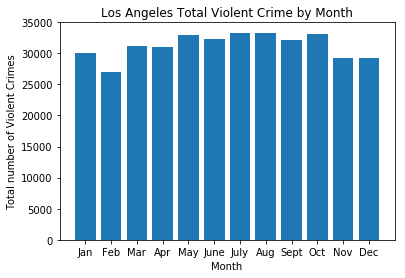

In [4]:
#DATA ANALYSIS

# Create a bar graph for the MONTHLY distribution of violent crimes
violent = pd.read_csv("Data/Violent_Crimes_Complete.csv")

months = violent.groupby("Month").count()
months_axis  = ["Jan","Feb","Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
monthly_crime = months["area_name"]

#Plot
plt.bar(months_axis, monthly_crime)
plt.title("Los Angeles Total Violent Crime by Month")
plt.xlabel("Month")
plt.ylabel("Total number of Violent Crimes")
plt.savefig("Resources/Monthly.png")

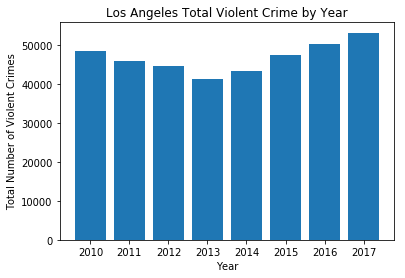

In [5]:
# Create a bar graph for the YEARLY distribution of violent crimes
years = violent.groupby("Year").count()
years_axis = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]
yearly_crime = years["area_name"]

#Plot

plt.bar(years_axis, yearly_crime)
plt.title("Los Angeles Total Violent Crime by Year")
plt.xlabel("Year")
plt.ylabel("Total Number of Violent Crimes")
plt.savefig("Resources/Yearly.png")

In [6]:
#Create Line Chart for the top 10 violent crimes 
years = violent.groupby("Year").count()

# Define X and Y axis

incidents = np.arange(0,50000,200)
Top_10_V_Crime_Freq_Years = (["BATTERY - SIMPLE ASSAULT", "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "ROBBERY", "INTIMATE PARTNER - AGGRAVATED ASSAULT", "BURGLARY, ATTEMPTED", "BATTERY WITH SEXUAL CONTACT", "RAPE, FORCIBLE", "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT", "CHILD NEGLECT (SEE 300 W.I.C.)", "CRIMINAL HOMICIDE"])
years_axis1 = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

In [7]:
# Prepare date for the Line Chart 2010-1017 Trend of the Top 10 crimes

Battery_Simple_Assault = [20520, 19905, 19819, 18927, 18407, 17593, 17924, 19156]
Assault_With_Deadly_Weapon_Agg_Assault = [8348, 7921, 7530, 7014, 8319, 10201, 10804, 11020]
Robbery = [9558, 8788, 7834, 6889, 6937, 7874, 9074, 9534]
Intimate_Partner_Agg_Assault = [227, 220, 260, 393, 1031, 2228, 2466, 2789]
Burglary_Attempted = [1392, 1353, 1285, 1211, 1166, 1318, 1243, 1376]
Battery_W_Sexual_Contact = [1041, 1019, 1039, 958, 1093, 1077, 1132, 1878]
Rape_Forcible = [896, 814, 878, 831, 1004, 1158, 1179, 1190]
Child_Abuse_Physical = [1087, 842, 931, 837, 811, 803, 943, 919]
Child_Neglect = [915, 844, 810, 521, 529, 385, 340, 315]
Criminal_Homicide = [590, 596, 596, 500, 520, 564, 586, 562]

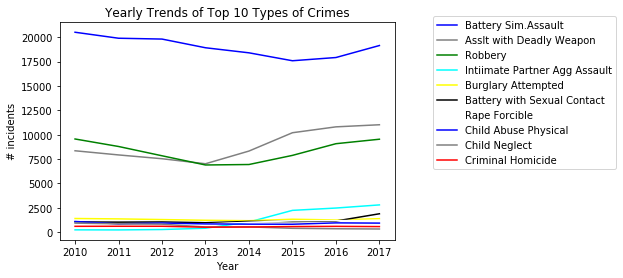

In [8]:
#Plot 

BSA, = plt.plot(years_axis1, Battery_Simple_Assault, color="blue", label="Battery Sim.Assault")
AWDW, = plt.plot(years_axis1, Assault_With_Deadly_Weapon_Agg_Assault, color="grey", label="Asslt with Deadly Weapon")
ROBB, = plt.plot(years_axis1, Robbery, color="green", label="Robbery")
IPAA, = plt.plot(years_axis1, Intimate_Partner_Agg_Assault, color="cyan", label="Intiimate Partner Agg Assault")
BA, = plt.plot(years_axis1, Burglary_Attempted, color="yellow", label="Burglary Attempted")
BWSC, = plt.plot(years_axis1, Battery_W_Sexual_Contact, color="black", label="Battery with Sexual Contact")
RF, = plt.plot(years_axis1, Rape_Forcible, color="white", label="Rape Forcible")
CAP, = plt.plot(years_axis1, Child_Abuse_Physical, color="blue", label="Child Abuse Physical")
CN, = plt.plot(years_axis1, Child_Neglect, color="grey", label="Child Neglect")
CH, = plt.plot(years_axis1, Criminal_Homicide, color="red", label="Criminal Homicide")

# Add labels, titles
plt.title("Yearly Trends of Top 10 Types of Crimes")
plt.xlabel("Year")
plt.ylabel("# incidents")
plt.legend(bbox_to_anchor=(1.1,1.05))

# Save Chart 
plt.savefig("Resources/Top10Trend.png")

In [9]:
#violent_crimes=pd.read_csv("Data/Violent_crimes_Complete_Last1.csv")
crime = violent.groupby(["Month","crm_cd_desc"]).count()
print(crime)

                                                          Unnamed: 0  area_id  \
Month crm_cd_desc                                                               
1     ARSON                                                      257      257   
      ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER               103      103   
      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT            5369     5369   
      BATTERY - SIMPLE ASSAULT                                 11723    11723   
      BATTERY ON A FIREFIGHTER                                    16       16   
      BATTERY POLICE (SIMPLE)                                    301      301   
      BATTERY WITH SEXUAL CONTACT                                729      729   
      BURGLARY, ATTEMPTED                                        930      930   
      CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT                158      158   
      CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT                    612      612   
      CHILD NEGLECT (SEE 300

In [10]:
Crimes_Per_month = pd.DataFrame(crime).reset_index()

In [11]:
Jan=Crimes_Per_month.loc[Crimes_Per_month["Month"]==1]
Feb=Crimes_Per_month.loc[Crimes_Per_month["Month"]==2]
Mar=Crimes_Per_month.loc[Crimes_Per_month["Month"]==3]
Apr=Crimes_Per_month.loc[Crimes_Per_month["Month"]==4]
May=Crimes_Per_month.loc[Crimes_Per_month["Month"]==5]
Jun=Crimes_Per_month.loc[Crimes_Per_month["Month"]==6]
Jul=Crimes_Per_month.loc[Crimes_Per_month["Month"]==7]
Aug=Crimes_Per_month.loc[Crimes_Per_month["Month"]==8]
Sep=Crimes_Per_month.loc[Crimes_Per_month["Month"]==9]
Oct=Crimes_Per_month.loc[Crimes_Per_month["Month"]==10]
Nov=Crimes_Per_month.loc[Crimes_Per_month["Month"]==11]
Dec=Crimes_Per_month.loc[Crimes_Per_month["Month"]==12]
print(Dec)


     Month                                        crm_cd_desc  Unnamed: 0  \
473     12                                              ARSON         253   
474     12       ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER         101   
475     12     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        5593   
476     12                           BATTERY - SIMPLE ASSAULT       11601   
477     12                           BATTERY ON A FIREFIGHTER          19   
478     12                            BATTERY POLICE (SIMPLE)         271   
479     12                        BATTERY WITH SEXUAL CONTACT         662   
480     12                                BURGLARY, ATTEMPTED         938   
481     12        CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT          79   
482     12            CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT         456   
483     12                     CHILD NEGLECT (SEE 300 W.I.C.)         310   
484     12                                  CHILD PORNOGRAPHY           1   

In [12]:
incidents = np.arange(0,50000,200)
Top_10_V_Crime_Freq_Month = (["BATTERY - SIMPLE ASSAULT", "ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT", "ROBBERY", "INTIMATE PARTNER - AGGRAVATED ASSAULT", "BURGLARY, ATTEMPTED", "BATTERY WITH SEXUAL CONTACT", "RAPE, FORCIBLE", "CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT", "CHILD NEGLECT (SEE 300 W.I.C.)", "CRIMINAL HOMICIDE"])
month_axis1 = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [13]:
# Prepare date for the Line Chart 2010-1017 Trend of the Top 10 crimes
Battery_Simple_Assault1 = [11723,11009,12856,12648,13725,13099,13525,13570,13242,13586,11667,11601                          ]
Assault_With_Deadly_Weapon_Agg_Assault1 = [5369,4991,5819,5786,6174,6442,6578,6561,6099,6224,5521,5593]
Robbery1 = [5555,4662,5297,5306,5718,5458,6009,5949,5572,5982,5457,5523]
Intimate_Partner_Agg_Assault1 = [713,673,771,763,813,825,879,837,849,831,849,811]
Burglary_Attempted1 = [930,749,910,850,882,835,835,865,861,841,848,938]
Battery_W_Sexual_Contact1 = [728,685,716,724,760,697,696,767,768,758,686,661]
Rape_Forcible1 = [745,614,635,632,655,707,698,686,667,716,625,570]
Child_Abuse_Physical1 = [611,578,710,696,706,553,440,524,639,717,543,456]
Child_Neglect1 = [412,370,439,392,422,392,367,419,394,408,334,310]
Criminal_Homicide1 = [414,282,368,420,386,406,384,416,370,386,336,346]



In [14]:
len(Criminal_Homicide1)

12

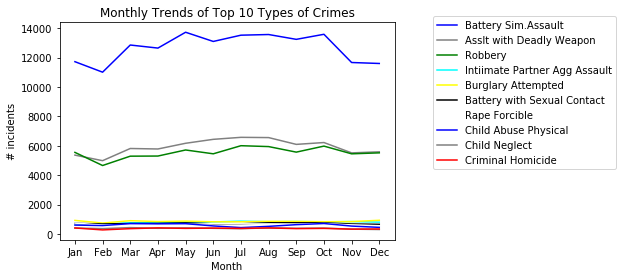

In [16]:
#Create Line Chart
BSA1, = plt.plot(month_axis1, Battery_Simple_Assault1, color="blue", label="Battery Sim.Assault")
AWDW1, = plt.plot(month_axis1, Assault_With_Deadly_Weapon_Agg_Assault1, color="grey", label="Asslt with Deadly Weapon")
ROBB1, = plt.plot(month_axis1, Robbery1, color="green", label="Robbery")
IPAA1, = plt.plot(month_axis1, Intimate_Partner_Agg_Assault1, color="cyan", label="Intiimate Partner Agg Assault")
BA1, = plt.plot(month_axis1, Burglary_Attempted1, color="yellow", label="Burglary Attempted")
BWSC1, = plt.plot(month_axis1, Battery_W_Sexual_Contact1, color="black", label="Battery with Sexual Contact")
RF1, = plt.plot(month_axis1, Rape_Forcible1, color="white", label="Rape Forcible")
CAP1, = plt.plot(month_axis1, Child_Abuse_Physical1, color="blue", label="Child Abuse Physical")
CN1, = plt.plot(month_axis1, Child_Neglect1, color="grey", label="Child Neglect")
CH1, = plt.plot(month_axis1, Criminal_Homicide1, color="red", label="Criminal Homicide")
# Add labels, titles
plt.title("Monthly Trends of Top 10 Types of Crimes")
plt.xlabel("Month")
plt.ylabel("# incidents")
plt.legend(bbox_to_anchor=(1.1,1.05))
# Save Chart 
plt.savefig("Resources/Top10TrendMonth.png")

In [17]:
Month_Crime_df=[]

In [18]:
crime_2010 = violent.loc[violent["Year"]==2010]
crime_2010 = crime_2010.groupby("Zip Code").count().reset_index()
crime_2010 = crime_2010[["Zip Code", "crm_cd_1"]]
crime_2010 = crime_2010.rename(columns={"crm_cd_1": "2010 Crime count"})

crime_2011 = violent.loc[violent["Year"]==2011]
crime_2011 = crime_2011.groupby("Zip Code").count().reset_index()
crime_2011 = crime_2011[["Zip Code", "crm_cd_1"]]
crime_2011 = crime_2011.rename(columns={"crm_cd_1": "2011 Crime count"})


crime_2012 = violent.loc[violent["Year"]==2012]
crime_2012 = crime_2012.groupby("Zip Code").count().reset_index()
crime_2012 = crime_2012[["Zip Code", "crm_cd_1"]]
crime_2012 = crime_2012.rename(columns={"crm_cd_1": "2012 Crime count"})


crime_2013 = violent.loc[violent["Year"]==2013]
crime_2013 = crime_2013.groupby("Zip Code").count().reset_index()
crime_2013 = crime_2013[["Zip Code", "crm_cd_1"]]
crime_2013 = crime_2013.rename(columns={"crm_cd_1": "2013 Crime count"})


crime_2014 = violent.loc[violent["Year"]==2014]
crime_2014 = crime_2014.groupby("Zip Code").count().reset_index()
crime_2014 = crime_2014[["Zip Code", "crm_cd_1"]]
crime_2014 = crime_2014.rename(columns={"crm_cd_1": "2014 Crime count"})


crime_2015 = violent.loc[violent["Year"]==2015]
crime_2015 = crime_2015.groupby("Zip Code").count().reset_index()
crime_2015 = crime_2015[["Zip Code", "crm_cd_1"]]
crime_2015 = crime_2015.rename(columns={"crm_cd_1": "2015 Crime count"})


crime_2016 = violent.loc[violent["Year"]==2016]
crime_2016 = crime_2016.groupby("Zip Code").count().reset_index()
crime_2016 = crime_2016[["Zip Code", "crm_cd_1"]]
crime_2016 = crime_2016.rename(columns={"crm_cd_1": "2016 Crime count"})


crime_2017 = violent.loc[violent["Year"]==2017]
crime_2017 = crime_2017.groupby("Zip Code").count().reset_index()
crime_2017 = crime_2017[["Zip Code", "crm_cd_1"]]
crime_2017 = crime_2017.rename(columns={"crm_cd_1": "2017 Crime count"})


Creating the crime counts by year

In [19]:
crime_by_year = crime_2010.merge(crime_2011, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2012, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2013, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2014, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2015, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2016, on="Zip Code", how = "outer")
crime_by_year = crime_by_year.merge(crime_2017, on="Zip Code", how = "outer")

In [20]:
len(crime_2015)

138

In [21]:
crime_by_year

,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count
0,90001.0,113.0,122.0,81.0,95.0,87.0,82.0,62.0,98.0
1,90002.0,935.0,981.0,873.0,785.0,856.0,778.0,874.0,943.0
2,90003.0,2400.0,2202.0,2274.0,2092.0,2144.0,2159.0,2396.0,2491.0
3,90004.0,469.0,339.0,393.0,450.0,362.0,420.0,438.0,454.0
4,90005.0,418.0,418.0,405.0,355.0,408.0,354.0,371.0,447.0
5,90006.0,813.0,749.0,729.0,697.0,812.0,764.0,706.0,768.0
6,90007.0,726.0,649.0,671.0,589.0,655.0,634.0,686.0,702.0
7,90008.0,589.0,561.0,569.0,541.0,566.0,552.0,547.0,555.0
8,90010.0,287.0,290.0,293.0,274.0,354.0,313.0,364.0,380.0
9,90011.0,1520.0,1374.0,1200.0,1050.0,1039.0,1175.0,1381.0,1241.0


In [26]:
#Use uszipsearch to collect information about the population size at each zipcode in our dataset. We need this information to be able to/
#calculate the violent crimte rates
populations = []
for index, row in crime_by_year.iterrows():

    #Get zipcodes based on lat-longs
    try:
        violent_zip = row["Zip Code"]
        population_zip = search.by_zipcode(violent_zip)
        populations.append(population_zip["Population"])
    except:
        populations.append("NaN")
        print(f"exception encountered")


crime_by_year["Population"] = populations

exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception encountered
exception 

In [27]:
crime_by_year.reset_index()

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population
0,0,90001.0,113.0,122.0,81.0,95.0,87.0,82.0,62.0,98.0,NaN
1,1,90002.0,935.0,981.0,873.0,785.0,856.0,778.0,874.0,943.0,NaN
2,2,90003.0,2400.0,2202.0,2274.0,2092.0,2144.0,2159.0,2396.0,2491.0,NaN
3,3,90004.0,469.0,339.0,393.0,450.0,362.0,420.0,438.0,454.0,NaN
4,4,90005.0,418.0,418.0,405.0,355.0,408.0,354.0,371.0,447.0,NaN
5,5,90006.0,813.0,749.0,729.0,697.0,812.0,764.0,706.0,768.0,NaN
6,6,90007.0,726.0,649.0,671.0,589.0,655.0,634.0,686.0,702.0,NaN
7,7,90008.0,589.0,561.0,569.0,541.0,566.0,552.0,547.0,555.0,NaN
8,8,90010.0,287.0,290.0,293.0,274.0,354.0,313.0,364.0,380.0,NaN
9,9,90011.0,1520.0,1374.0,1200.0,1050.0,1039.0,1175.0,1381.0,1241.0,NaN


In [87]:
#Calculate the violent crime rate for each year in our dataset

crime_by_year["2010 Crime Rate"]= crime_by_year["2010 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2011 Crime Rate"]= crime_by_year["2011 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2012 Crime Rate"]= crime_by_year["2012 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2013 Crime Rate"]= crime_by_year["2013 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2014 Crime Rate"]= crime_by_year["2014 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2015 Crime Rate"]= crime_by_year["2015 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2016 Crime Rate"]= crime_by_year["2016 Crime count"]/crime_by_year["Population"]*100000
crime_by_year["2017 Crime Rate"]= crime_by_year["2017 Crime count"]/crime_by_year["Population"]*100000

In [88]:
crime_by_year = crime_by_year.dropna()
crime_by_year = crime_by_year.reset_index()

In [89]:
crime_by_year

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate
0,0,90001,113.0,122.0,81.0,95.0,87.0,82.0,62.0,98.0,57110.0,1.978638e+02,2.136228e+02,1.418316e+02,1.663456e+02,1.523376e+02,1.435826e+02,1.085624e+02,1.715987e+02
1,1,90002,935.0,980.0,873.0,785.0,856.0,778.0,874.0,943.0,51223.0,1.825352e+03,1.913203e+03,1.704313e+03,1.532515e+03,1.671124e+03,1.518849e+03,1.706265e+03,1.840970e+03
2,2,90003,2400.0,2202.0,2274.0,2092.0,2144.0,2159.0,2395.0,2487.0,66266.0,3.621767e+03,3.322971e+03,3.431624e+03,3.156973e+03,3.235445e+03,3.258081e+03,3.614221e+03,3.753056e+03
3,3,90004,469.0,339.0,393.0,450.0,362.0,420.0,438.0,454.0,62180.0,7.542618e+02,5.451914e+02,6.320360e+02,7.237054e+02,5.821808e+02,6.754583e+02,7.044066e+02,7.301383e+02
4,4,90005,418.0,418.0,405.0,355.0,408.0,354.0,371.0,446.0,37681.0,1.109312e+03,1.109312e+03,1.074812e+03,9.421194e+02,1.082774e+03,9.394655e+02,9.845811e+02,1.183620e+03
5,5,90006,813.0,749.0,729.0,697.0,812.0,764.0,706.0,768.0,59185.0,1.373659e+03,1.265523e+03,1.231731e+03,1.177663e+03,1.371969e+03,1.290868e+03,1.192870e+03,1.297626e+03
6,6,90007,726.0,649.0,671.0,589.0,655.0,634.0,686.0,701.0,40920.0,1.774194e+03,1.586022e+03,1.639785e+03,1.439394e+03,1.600684e+03,1.549365e+03,1.676442e+03,1.713099e+03
7,7,90008,589.0,561.0,569.0,541.0,566.0,552.0,547.0,555.0,32327.0,1.822006e+03,1.735391e+03,1.760139e+03,1.673524e+03,1.750858e+03,1.707551e+03,1.692084e+03,1.716831e+03
8,8,90010,287.0,290.0,293.0,274.0,354.0,313.0,364.0,380.0,3800.0,7.552632e+03,7.631579e+03,7.710526e+03,7.210526e+03,9.315789e+03,8.236842e+03,9.578947e+03,1.000000e+04
9,9,90011,1520.0,1374.0,1200.0,1050.0,1039.0,1175.0,1381.0,1241.0,103892.0,1.463058e+03,1.322527e+03,1.155046e+03,1.010665e+03,1.000077e+03,1.130982e+03,1.329265e+03,1.194510e+03


In [90]:
#Statistical Analysis and Simple Regressions 

from scipy.stats import linregress
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

raw_crime_change = []
raw_crime_intercept = []
p_val = []

for x in range(len(crime_by_year)):

   #Get zipcodes based on lat-longs
   try:
       crime_10 = crime_by_year["2010 Crime count"][x]
       crime_11 = crime_by_year["2011 Crime count"][x]
       crime_12 = crime_by_year["2012 Crime count"][x]
       crime_13 = crime_by_year["2013 Crime count"][x]
       crime_14 = crime_by_year["2014 Crime count"][x]
       crime_15 = crime_by_year["2015 Crime count"][x]
       crime_16 = crime_by_year["2016 Crime count"][x]
       crime_17 = crime_by_year["2017 Crime count"][x]
       yearly_rate = [crime_10, crime_11, crime_12, crime_13, crime_14, crime_15, crime_16, crime_17]
       (raw_slope, raw_intercept, _, p_val,_ ) = linregress(years, yearly_rate)
       raw_crime_change.append(raw_slope)
       raw_crime_intercept.append(raw_intercept)

   except:
       print("crime change could not be calculated")

crime_by_year["Raw Slope of Regression"] = raw_crime_change
crime_by_year["Raw Intercept"] = raw_crime_intercept
crime_by_year["p value"]=p_val


In [91]:

years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

crime_change = []
for x in range(len(crime_by_year)):

    #Get zipcodes based on lat-longs
    try:
        crime_10 = crime_by_year["2010 Crime Rate"][x]
        crime_11 = crime_by_year["2011 Crime Rate"][x]
        crime_12 = crime_by_year["2012 Crime Rate"][x]
        crime_13 = crime_by_year["2013 Crime Rate"][x]
        crime_14 = crime_by_year["2014 Crime Rate"][x]
        crime_15 = crime_by_year["2015 Crime Rate"][x]
        crime_16 = crime_by_year["2016 Crime Rate"][x]
        crime_17 = crime_by_year["2017 Crime Rate"][x]
        yearly_rate = [crime_10, crime_11, crime_12, crime_13, crime_14, crime_15, crime_16, crime_17]
        (slope, _, _, _, _) = linregress(years, yearly_rate)
        crime_change.append(slope)

    except:
        print("crime change could not be calculated")

crime_by_year["Slope of Regression"] = crime_change


C:\Users\elean\Anaconda3\envs\PythonData\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\elean\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\elean\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\elean\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [93]:
crime_by_year

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression
0,0,90001,113.0,122.0,81.0,95.0,87.0,82.0,62.0,98.0,57110.0,1.978638e+02,2.136228e+02,1.418316e+02,1.663456e+02,1.523376e+02,1.435826e+02,1.085624e+02,1.715987e+02,-4.880952,9920.297619,0.513355,-8.546581
1,1,90002,935.0,980.0,873.0,785.0,856.0,778.0,874.0,943.0,51223.0,1.825352e+03,1.913203e+03,1.704313e+03,1.532515e+03,1.671124e+03,1.518849e+03,1.706265e+03,1.840970e+03,-8.190476,17369.523810,0.513355,-15.989841
2,2,90003,2400.0,2202.0,2274.0,2092.0,2144.0,2159.0,2395.0,2487.0,66266.0,3.621767e+03,3.322971e+03,3.431624e+03,3.156973e+03,3.235445e+03,3.258081e+03,3.614221e+03,3.753056e+03,15.250000,-28436.750000,0.513355,23.013310
3,3,90004,469.0,339.0,393.0,450.0,362.0,420.0,438.0,454.0,62180.0,7.542618e+02,5.451914e+02,6.320360e+02,7.237054e+02,5.821808e+02,6.754583e+02,7.044066e+02,7.301383e+02,4.559524,-8764.976190,0.513355,7.332782
4,4,90005,418.0,418.0,405.0,355.0,408.0,354.0,371.0,446.0,37681.0,1.109312e+03,1.109312e+03,1.074812e+03,9.421194e+02,1.082774e+03,9.394655e+02,9.845811e+02,1.183620e+03,-1.654762,3728.738095,0.513355,-4.391502
5,5,90006,813.0,749.0,729.0,697.0,812.0,764.0,706.0,768.0,59185.0,1.373659e+03,1.265523e+03,1.231731e+03,1.177663e+03,1.371969e+03,1.290868e+03,1.192870e+03,1.297626e+03,-3.690476,8185.523810,0.513355,-6.235492
6,6,90007,726.0,649.0,671.0,589.0,655.0,634.0,686.0,701.0,40920.0,1.774194e+03,1.586022e+03,1.639785e+03,1.439394e+03,1.600684e+03,1.549365e+03,1.676442e+03,1.713099e+03,-0.416667,1502.833333,0.513355,-1.018247
7,7,90008,589.0,561.0,569.0,541.0,566.0,552.0,547.0,555.0,32327.0,1.822006e+03,1.735391e+03,1.760139e+03,1.673524e+03,1.750858e+03,1.707551e+03,1.692084e+03,1.716831e+03,-3.976190,8566.059524,0.513355,-12.299906
8,8,90010,287.0,290.0,293.0,274.0,354.0,313.0,364.0,380.0,3800.0,7.552632e+03,7.631579e+03,7.710526e+03,7.210526e+03,9.315789e+03,8.236842e+03,9.578947e+03,1.000000e+04,13.821429,-27510.071429,0.513355,363.721805
9,9,90011,1520.0,1374.0,1200.0,1050.0,1039.0,1175.0,1381.0,1241.0,103892.0,1.463058e+03,1.322527e+03,1.155046e+03,1.010665e+03,1.000077e+03,1.130982e+03,1.329265e+03,1.194510e+03,-23.857143,49283.857143,0.513355,-22.963407


In [94]:
crime_by_year.to_csv("data/Crime_By_Year_1.csv")

In [95]:
the90071 = crime_by_year.loc[crime_by_year["Zip Code"]=="90071"]
the90071

years = [2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0]
years = np.array(years)

crimes_in_90071 = [168.0, 146, 149, 175, 200, 241, 250, 306]
crimes_in_90071_fit = 21.274*years-42630

In [96]:
the90071

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression
58,58,90071,350.0,327.0,302.0,334.0,373.0,515.0,457.0,608.0,15.0,2.333333e+06,2180000.0,2.013333e+06,2.226667e+06,2.486667e+06,3.433333e+06,3.046667e+06,4.053333e+06,37.309524,-74714.47619,0.513355,248730.15873


In [97]:
crimes_in_90071 = [169, 147, 149, 176, 202, 242, 251, 306]

Text(0.5,1,'Crime in 90071: the fasest growing crime rate')

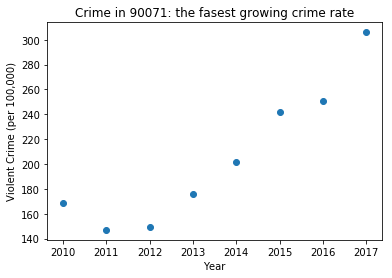

In [98]:
plt.scatter(years, crimes_in_90071)
plt.plot(years,crimes_in_90071_fit,"r--")
plt.xlabel("Year")
plt.ylabel("Violent Crimes (total number)")
plt.title("Crime in 90071: the fasest growing crime rate")
plt.savefig("resources/rising_crime_90071.png")

In [99]:
the90017 = crime_by_year.loc[crime_by_year["Zip Code"]=="90017"]
the90017

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression
15,15,90017,822.0,838.0,714.0,657.0,668.0,854.0,787.0,848.0,23768.0,3458.431505,3525.748906,3004.039044,2764.220801,2810.501515,3593.066308,3311.174689,3567.822282,4.261905,-7807.845238,0.513355,17.931272


In [100]:
crimes_in_90017 = [642, 710,638, 536, 533, 625, 576, 598]

Text(0.5,1,'90017: seeing a large decline in crime')

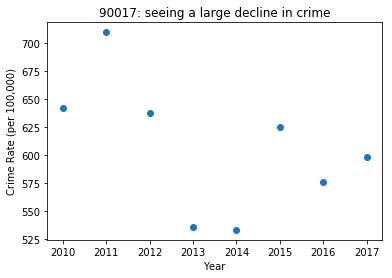

In [101]:
crimes_in_90017 = [2616.963985, 2970.380343,2663.244699, 2250.925614, 2234.096264, 2616.963985, 2410.804443, 2503.36587]
fit_90017 = -44.627831 * years+92391

plt.scatter(years, crimes_in_90017)
plt.plot(years, fit_90017, "r--")
plt.xlabel("Year")
plt.ylabel("Crime Rate (per 100,000)")
plt.title("90017: seeing a large decline in crime")
plt.savefig("resources/90017_declining.png")


In [102]:
#Create a pie chart for the share of type of crime between 2010 to 2017
crimes_df = crime_df.loc[crime_df["Year"]!=2018]

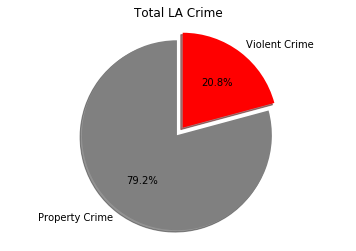

In [106]:
# Calculating the number of property crimesAny crime that is not a violent crime is de facto a property crime
property_crime = len(crime_df) - len(violent_crimes)
plt.pie([property_crime, len(violent_crimes)], labels=["Property Crime", "Violent Crime"], autopct="%1.1f%%", explode=[0, 0.1], colors=["gray", "red"],shadow=0.3, startangle= 90)
plt.title("Total LA Crime")
plt.axis("equal")
plt.savefig("resources/Total LA crime pie chart.png")

In [107]:
the90042 = crime_by_year.loc[crime_by_year["Zip Code"]=="90042"]
the90042

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression
37,37,90042,500.0,410.0,421.0,357.0,403.0,467.0,363.0,388.0,62430.0,800.897005,656.735544,674.355278,571.840461,645.522986,748.037802,581.451225,621.496076,-9.940476,20428.77381,0.513355,-15.922595


In [108]:
crimes_in_90042 = [378,336,349,287,298,304,264,253]

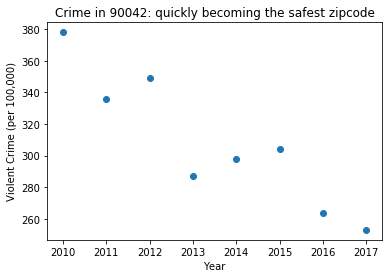

In [109]:
plt.scatter(years, crimes_in_90042)
plt.xlabel("Year")
plt.ylabel("Violent Crime (per 100,000)")
plt.title("Crime in 90042: quickly becoming the safest zipcode")

plt.savefig("resources/90071.png")

In [110]:
sig_crime_by_year = crime_by_year.loc[crime_by_year["p value"]<0.05]
sig_crime_by_year

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression


In [111]:
pos = len(sig_crime_by_year["Slope of Regression"]>0)
neg = len(sig_crime_by_year["Slope of Regression"]<0)

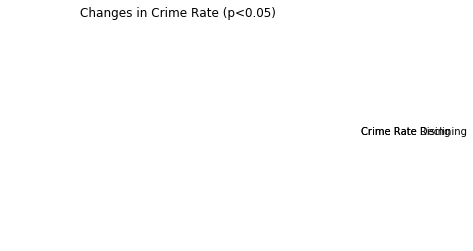

In [112]:
plt.pie([pos, neg], labels=["Crime Rate Rising", "Crime Rate Declining"])
plt.axis("equal")
plt.title("Changes in Crime Rate (p<0.05)")
plt.savefig("resources/Changes_in_Crime_Rate.png")

In [113]:
the90006 = crime_by_year.loc[crime_by_year["Zip Code"]=="90006"]
the90006

,index,Zip Code,2010 Crime count,2011 Crime count,2012 Crime count,2013 Crime count,2014 Crime count,2015 Crime count,2016 Crime count,2017 Crime count,Population,2010 Crime Rate,2011 Crime Rate,2012 Crime Rate,2013 Crime Rate,2014 Crime Rate,2015 Crime Rate,2016 Crime Rate,2017 Crime Rate,Raw Slope of Regression,Raw Intercept,p value,Slope of Regression
5,5,90006,813.0,749.0,729.0,697.0,812.0,764.0,706.0,768.0,59185.0,1373.658866,1265.523359,1231.731013,1177.663259,1371.969249,1290.867618,1192.869815,1297.626088,-3.690476,8185.52381,0.513355,-6.235492


In [114]:
crimes_in_90006 = [1,5,4,3,9,8,30,120]

In [115]:
sp_fit = 19.63 * years-39490.0
#ax8.plot(df.iloc[:,0], sp_fit, 'r--')

TypeError: can't multiply sequence by non-int of type 'float'

In [1]:
#Making separate dataframes for crimes againstmen and crimes against women
men = violent_crimes.loc[violent_crimes["vict_sex"]=="M"]
women = violent_crimes.loc[violent_crimes["vict_sex"]=="F"]

#Plotting victim age separated by sex
plt.hist([men["vict_age"].dropna(),women["vict_age"].dropna()], color=["blue","palevioletred"])
plt.xlabel("Victim Age")
plt.ylabel("Number of Victims")
plt.legend(["Male", "Female"])
plt.title("Number of Victims by Sex and Age")
plt.savefig("resources/vict_sex_age.png")

NameError: name 'violent_crimes' is not defined

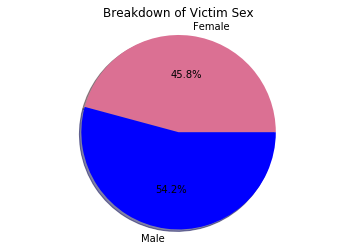

In [119]:
plt.pie ([len(women), len(men)], labels=["Female","Male"], colors=["palevioletred", "blue"], autopct="%1.1f%%", shadow=True)
plt.title("Breakdown of Victim Sex")
plt.axis("equal")
plt.savefig("resources/victim_sex_pie_chart.png")


0.06773722644579387
571.8995140565285
0.0015821633571121289


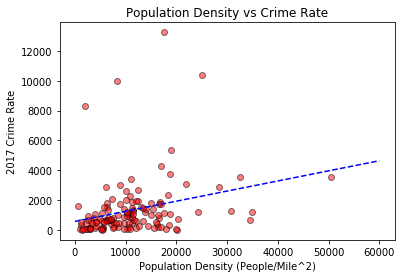

In [123]:
#Adding column of zipcode areas which will be used to calculate density
areas = []
for index, row in crime_by_year.iterrows():

   #Get zipcodes based on lat-longs
   try:
       zips = row["Zip Code"]
       zip_area = search.by_zipcode(zips)
       areas.append(zip_area["LandArea"])
   except:
       areas.append("NaN")
       print(f"exception encountered")


crime_by_year["Area"] = areas
crime_by_year["Density"] = crime_by_year["Population"]/crime_by_year["Area"]

#Filtering out zipcodes with spuriously low populations
crime_by_year = crime_by_year.loc[crime_by_year["Population"]>20]
crime_by_year = crime_by_year.dropna()

from scipy.stats import linregress

#Calculating slope, intercept and p-value for linear regression of density vs crime rate
crime_by_year = crime_by_year.loc[crime_by_year["Population"]>20]
crime_by_year = crime_by_year.dropna()

(den_slope, den_intercept, _, denp_value,_ ) = linregress(crime_by_year["Density"], crime_by_year["2017 Crime Rate"])
print(den_slope)
print(den_intercept)
print(denp_value)

#Creating a fit line
x_den = np.array([0,60000])
den_fit = den_slope*x_den + den_intercept

#Plotting density vs 2017 crime rate w/ fit line
plt.scatter(crime_by_year["Density"], crime_by_year["2017 Crime Rate"], alpha=0.5, color ="red", edgecolors="black")
plt.ylabel("2017 Crime Rate")
plt.xlabel("Population Density (People/Mile^2)")
plt.plot(x_den, den_fit, "b--")
plt.title("Population Density vs Crime Rate")
plt.savefig("resources/density_vs_crimerate.png")